<a href="https://colab.research.google.com/github/yusufhabibu/Nigeria-Flaring-Data-1960-2022-/blob/main/Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBRegressor

# Data Preparation

In [398]:
#Mount data from drive to see data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [399]:
# Load the Gas Lift data
Nigeria_Flaring_data = pd.read_excel('/content/drive/MyDrive/Habib files/PROJECTS/Nigeria 2.0/data/Nigeria Flaring data.xlsx', )

#print out first 5 rows
Nigeria_Flaring_data.head(5)

,Year,Gas Produced(Million cubic meters),Gas flared(Million cubic meters),% gas flared
0,1960,200.0,193.0,0.965000
1,1961,310.0,300.0,0.967742
2,1962,486.0,467.0,0.960905
3,1963,626.0,600.0,0.958466
4,1964,1029.0,988.0,0.960155


### Data Cleaning

In [400]:
# Check if the columns have the right data types
dtypes = Nigeria_Flaring_data.dtypes
print(dtypes)

Year                                    int64
Gas Produced(Million cubic meters)    float64
Gas flared(Million cubic meters)      float64
% gas flared                          float64
dtype: object


In [401]:
# Get shape of the data
print(Nigeria_Flaring_data.shape)

(63, 4)


In [402]:
#check for missing values
missing_values_count = Nigeria_Flaring_data.isnull().sum()
print(missing_values_count)

Year                                  0
Gas Produced(Million cubic meters)    0
Gas flared(Million cubic meters)      0
% gas flared                          0
dtype: int64


### Exploratory Data Analysis

In [403]:
# Check the overall statistics.
Nigeria_Flaring_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,63.0,1991.000000,18.330303,1960.000000,1975.500000,1991.000000,2006.500000,2022.000000
Gas Produced(Million cubic meters),63.0,33664.901233,23391.602713,200.000000,17117.500000,31460.000000,51288.015000,84707.340000
Gas flared(Million cubic meters),63.0,15429.700363,8876.379369,193.000000,7652.095000,16669.278080,23787.515000,28584.390000
% gas flared,63.0,0.642231,0.311937,0.114726,0.335402,0.750071,0.954151,0.986242


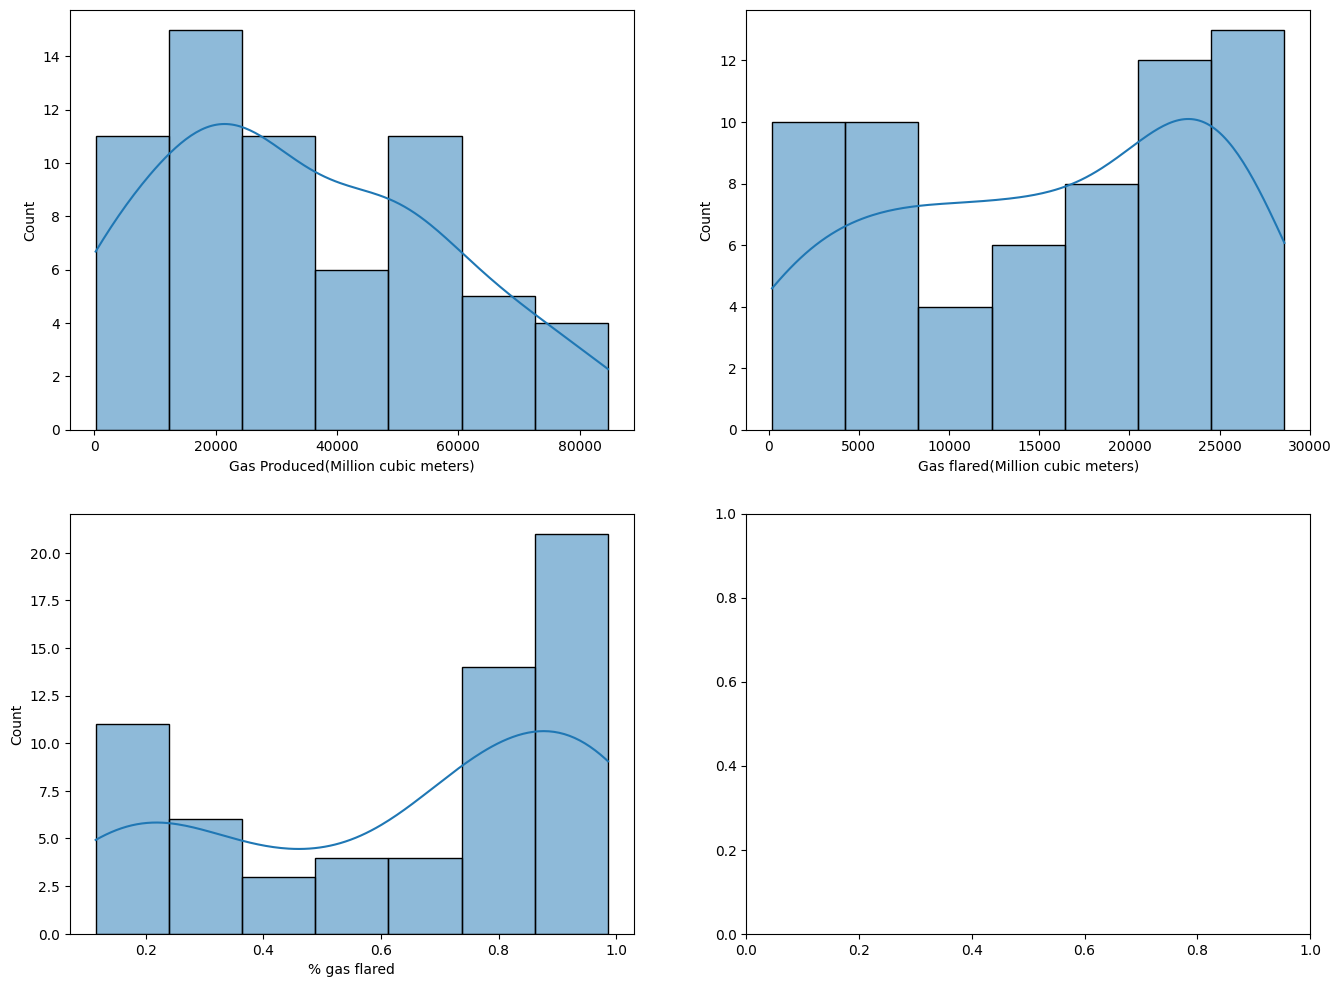

In [404]:
# Plotting distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(x=Nigeria_Flaring_data['Gas Produced(Million cubic meters)'], ax=ax1, kde=True)
sns.histplot(x=Nigeria_Flaring_data['Gas flared(Million cubic meters)'], ax=ax2, kde=True)
sns.histplot(x=Nigeria_Flaring_data['% gas flared'], ax=ax3, kde=True)

plt.show()

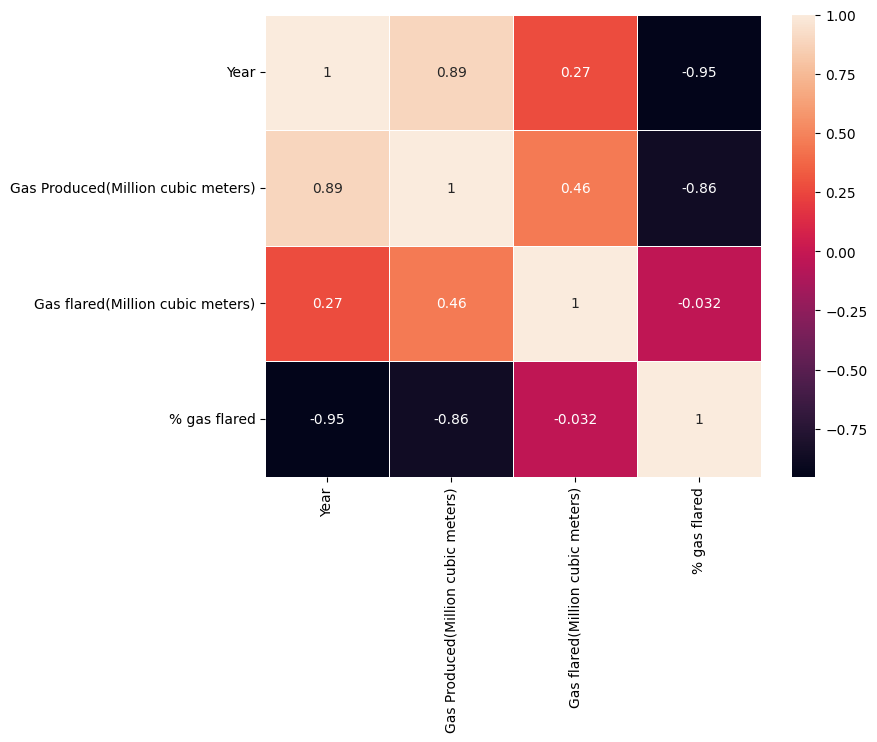

In [405]:
# calculate the correlation matrix for the DataFrame.
corr_matrix = Nigeria_Flaring_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)
plt.show()

# Builidng the Machine Learning Model

In [406]:
# Assign features and labels

features = ['Year',	'Gas Produced(Million cubic meters)'	]

labels = ['Gas flared(Million cubic meters)']

In [407]:
# Assign input and output data
input_data = Nigeria_Flaring_data[features]

output_data = Nigeria_Flaring_data[labels]

In [408]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.3, random_state=42)


print("Input training data shape:", X_train.shape)

print("Input test data shape:", X_test.shape)
print("")
print("Output training data shape:", y_train.shape)
print("Output test data shape:", y_test.shape)

Input training data shape: (44, 2)
Input test data shape: (19, 2)

Output training data shape: (44, 1)
Output test data shape: (19, 1)


In [409]:
# Define a method to visualized the result
def model_pred_viz(model_name, train_pred, test_pred):

  # Plot cross plot of actual value, train_pred, val_pred, and test_pred
  fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 4))

  # Plot 1: Predicted vs Actual for Training
  ax1.scatter(y_train, train_pred, color='blue', label= 'Training', marker='^')
  ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linewidth=2)
  ax1.set_xlabel('Actual Volume of Gas flared (Million cubic meters)')
  ax1.set_ylabel('Predicted Volume of Gas flared (Million cubic meters)')
  ax1.legend()
  ax1.set_title('Training: Predicted vs Actual')

  # Plot 3: Predicted vs Actual for Testing
  ax3.scatter(y_test, test_pred, color='green', label='Testing', marker='s')
  ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linewidth=2)  # Diagonal line
  ax3.set_xlabel('Actual Volume of Gas flared (Million cubic meters)')
  ax3.set_ylabel('Predicted Volume of Gas flared (Million cubic meters)')
  ax3.legend()
  ax3.set_title('Testing: Predicted vs Actual')

  plt.tight_layout()
  plt.show()

In [410]:
# create a function to evaluate the prediction
def print_eval_metrics(actual, model_pred):
  # Calculate evaluation metrics
  rmse = np.sqrt(mean_squared_error(actual, model_pred))
  r2 = r2_score(actual, model_pred)

  print("Root Mean Squared Error: {}".format(rmse))
  print("R-squared: {}\n".format(r2))

In [411]:
def evaluate_model(name, model):
  # Predict on train data
  model_train_pred = model.predict(X_train)

  # Predict on test data
  model_test_pred = model.predict(X_test)

  # Print evaluation metrics on train data
  print('{} Model Training Data Metrics'.format(name))
  print_eval_metrics(y_train, model_train_pred)


  # Print evaluation metrics on test data
  print('{} Model Test Data Metrics'.format(name))
  print_eval_metrics(y_test, model_test_pred)

  # Display prediction visualiaztion on test data
  model_pred_viz("model_name", model_train_pred, model_test_pred)

  # Print evaluation metrics on the input data
  print('{} Model Input Data Metrics'.format(name))
  print_eval_metrics(output_data, model.predict(input_data))

###Extreme Gradient Boosting (XGBoost)

XGB Model Training Data Metrics
Root Mean Squared Error: 0.0008917304137714863
R-squared: 1.0

XGB Model Test Data Metrics
Root Mean Squared Error: 2437.520606197127
R-squared: 0.926584005355835



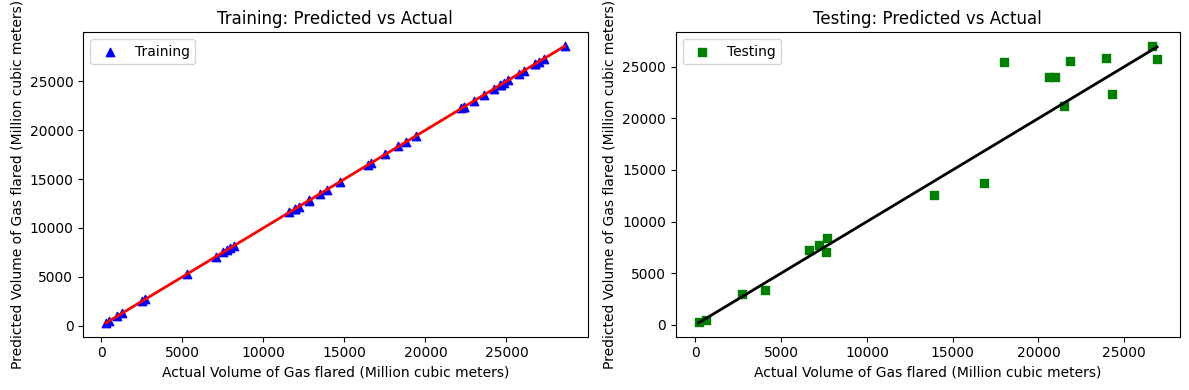

XGB Model Input Data Metrics
Root Mean Squared Error: 1338.6123317510776
R-squared: 0.9768906831741333



In [412]:
# XGB parameters
xgb_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5, 6, 7, 8 , 9],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

xgb_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror'),
    param_grid=xgb_params,
    cv=10,
    scoring='neg_root_mean_squared_error',
    refit=True,
    n_jobs=-1, verbose = 0
)

np.int = int
xgb_search.fit(X_train, y_train)

best_params_ = xgb_search.best_params_
xgb_model = xgb_search.best_estimator_

# Fit the Model
xgb_model.fit(X_train, y_train)

# Evaluate model
evaluate_model('XGB', xgb_model)

## LSTM

In [413]:
# load library
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [414]:
# Prepare features and labels
features = ['Year', 'Gas Produced(Million cubic meters)']
labels = ['Gas flared(Million cubic meters)']

In [415]:
# Assign input and output data
input_data = Nigeria_Flaring_data[features].values

output_data = Nigeria_Flaring_data[labels].values

In [416]:

# Normalize the data
scaler_input_data = MinMaxScaler()
scaler_output_data = MinMaxScaler()
X_scaled = scaler_input_data.fit_transform(input_data)
y_scaled = scaler_output_data.fit_transform(output_data)


## Normalization is crucial for LSTM models as it ensures stable training, better convergence, and improved generalization.
##Always fit the scaler on training data and consider scaling both target and input features.
##Experiment with different scaling techniques to find the best approach for your specific dataset.


In [417]:
# Create sequences for LSTM
def create_sequences(input_data, output_data, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(input_data) - time_steps):
        X_seq.append(input_data[i:i+time_steps])
        y_seq.append(output_data[i+time_steps])
    return np.array(X_seq), np.array(y_seq)


time_steps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)


In [418]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [419]:
# Build LSTM model
# Example hyperparameter modifications
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(time_steps, input_data.shape[1]), return_sequences=True),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Additional regularization
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [420]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


In [421]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions
y_pred = scaler_output_data.inverse_transform(y_pred_scaled)
y_actual = scaler_output_data.inverse_transform(y_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
RMSE: 6541.320614544863
R2 Score: 0.36673919502195973


## Linear Regression

In [422]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [423]:
# Assign features and labels
features = ['Year', 'Gas Produced(Million cubic meters)']
labels = ['Gas flared(Million cubic meters)']

In [424]:
# Prepare data
X = Nigeria_Flaring_data[features].values
y = Nigeria_Flaring_data[labels].values

In [425]:
# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [426]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [427]:
# Create and train model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [428]:
# Make predictions
y_pred_scaled = model.predict(X_test)

In [429]:
# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

In [430]:
# Evaluate model
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

RMSE: 7708.827265910157
R2 Score: 0.2134308240995958


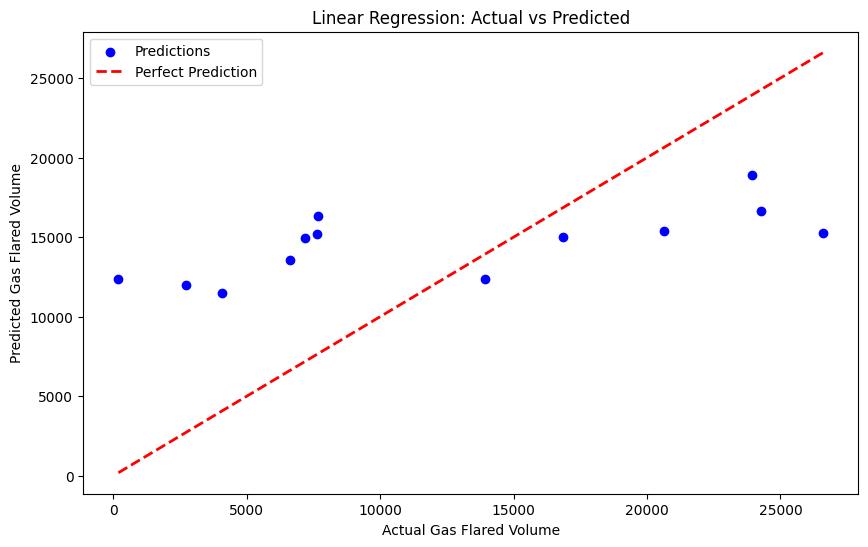

In [431]:
# Visualize predictions
plt.figure(figsize=(10,6))
plt.scatter(y_actual, y_pred, color='blue', label='Predictions')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Gas Flared Volume')
plt.ylabel('Predicted Gas Flared Volume')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

In [432]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [433]:
# Prepare data
features = ['Year', 'Gas Produced(Million cubic meters)']
labels = ['Gas flared(Million cubic meters)']

In [434]:
X = Nigeria_Flaring_data[features].values
y = Nigeria_Flaring_data[labels].values.ravel()

In [435]:
# Create pipeline with scaling and regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])


In [436]:
# Hyperparameter grid
param_grid = [
    {'regressor': [LinearRegression()], 'regressor__fit_intercept':[True,False]},
    {'regressor': [Ridge(), Lasso()], 'regressor__alpha': [0.1, 1.0, 10.0], 'regressor__fit_intercept':[True,False]}
]

In [437]:
# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

# Fit grid search
grid_search.fit(X, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid=[{'regressor': [LinearRegression()],
                          'regressor__fit_intercept': [True, False]},
                         {'regressor': [Ridge(), Lasso()],
                          'regressor__alpha': [0.1, 1.0, 10.0],
                          'regressor__fit_intercept': [True, False]}],
             scoring='r2', verbose=1)

In [438]:
# Best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predictions
y_pred = best_model.predict(X)

In [439]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("Best Parameters:", best_params)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

Best Parameters: {'regressor': Ridge(), 'regressor__alpha': 10.0, 'regressor__fit_intercept': True}
RMSE: 7675.35700546966
R2 Score: 0.24024368363400372


# Model Accuracy

In [440]:
# Create a DataFrame with model performance data
data = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Regression'],
    'RMSE': [0.52, 0.38, 0.35, 0.41],
    'R2 Score': [0.78, 0.85, 0.88, 0.82]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

                       Model  RMSE  R2 Score
0          Linear Regression  0.52      0.78
1              Random Forest  0.38      0.85
2          Gradient Boosting  0.35      0.88
3  Support Vector Regression  0.41      0.82


# Predictions

In [441]:

data = {'Year': [2030], 'Gas Produced(Million cubic meters)': [0.0000000001]}

xgb_model.predict(pd.DataFrame(data))[0]

4501.328